#### Initialzation

In [1]:
if True: # enable folding code
    if False:
        from julia.api import Julia
        jl = Julia(compiled_modules=False)

    import julia; julia.install(quiet=True)
    from julia import Main

    import holoviews as hv; hv.extension('bokeh', logo=False)
    import panel as pn; pn.extension()
    import param

    import itikz
    from itikz import nicematrix as nM

    import numpy as np
    import pandas as pd
    from math import atan2, degrees

    from IPython.display import display, Math

    np.set_printoptions(precision=3, suppress=True)

    try:
        from scipy.linalg import norm, inv, cholesky, qr, eig, eigh, qz, ordqz
        HAVE_SCIPY = True
    except Exception as e:
        HAVE_SCIPY = False
        print("SciPy not available;", e)

%load_ext julia.magic

Initializing Julia interpreter. This may take some time...


In [2]:
%%julia
using Pkg
gla_dir = "../GenLinAlgProblems"
Pkg.activate(gla_dir)
using GenLinAlgProblems, LinearAlgebra, BlockArrays, LaTeXStrings, Latexify, SymPy, Random

using PyCall
itikz = pyimport("itikz")
nM    = pyimport("itikz.nicematrix");

  Activating project at `C:\Users\jeff\NOTEBOOKS\elementary-linear-algebra\GenLinAlgProblems`


In [3]:
%%julia
# support functions used to display objects for discussion
"""
    classify_gsvd(F; tol = 1e-12)

Given a GSVD factorization object `F` (as returned by `svd(A,B)`),
recover the number of
  • pure-A   (alpha=1, beta=0)
  • mixed    (0<alpha<1, 0<beta<1)
  • pure-B   (alpha=0, beta=1)
  • nullspace (alpha=0, beta=0)

using the LAPACK structural constraints:

  - indices 1:k       → pure-A
  - indices k+1:k+l   → mixed OR pure-B
  - indices > k+l     → nullspace

Returns a named tuple.
"""
function classify_gsvd(F; tol=1e-12, show=true)
    alpha = F.alpha
    beta  = F.beta
    k     = F.k               # pure-A
    l     = F.l               # mixed + pure-B
    N     = length(alpha)
    r     = k + l             # rank

    # index partitions
    pureA_idx = 1:k
    mid_idx   = k+1 : k+l
    null_idx  = k+l+1 : N

    # pure A = exactly the first k indices by LAPACK definition
    npureA = k

    # pure B: among mid block, (alpha ≈ 0, beta ≈ 1)
    npureB = count(i -> abs(alpha[i]) < tol && abs(beta[i] - 1) < tol, mid_idx)

    # mixed: remaining mid-block entries where both alpha, beta are nonzero
    nmixed = l - npureB

    # nullspace: trailing (0,0) entries
    nnull = count(i -> abs(alpha[i]) < tol && abs(beta[i]) < tol, null_idx)

    if show
        py_show( L"pureA = ",        npureA,
                 L",\;\; mixed = ",  nmixed,
                 L",\;\ pureB = ",   npureB,
                 L",\;\;n_0 = ",     nnull )
    end

    return (
        n_A  = npureA,
        n_M  = nmixed,
        n_B  = npureB,
        n_0  = nnull,
        rank = r,
        n    = N
    )
end

"""
    res = function gsvd(A,B)

utility function to augmment ths svd(routine) with additional information
returns
* res.F   the GSVD standard structure
* res.X   the domain basis matrix
* res.C   the C matrix augmented by the n_0 block  (size(C) == size(A))
* res.S   the S matrix augmented by the n_0 block  (size(S) == size(B))
* res.sz  the sizes of the subspaces (n_A, n_M, n_B, n_0) and the combined rank
"""
function naive_gsvd(A,B)
    F = svd(A, B)
    U,V,Q,C,S,R = F
    H = R*Q'

    N = nullspace([A; B])
    X = size(N, 2) == 0 ? pinv(H) : [pinv(H) N]

    sz = classify_gsvd(F; show=false)
    if sz.n_0 > 0
        C = [C zeros(size(C,1), sz.n_0)]
        S = [S zeros(size(S,1), sz.n_0)]
    end

    m_A,N  = size(A)
    m_B  = size(B,1)

    spec = [ sz.n_A, sz.n_M, sz.n_B, sz.n_0]

    return (
        alpha=F.alpha, beta=F.beta,
        U=BlockArray(U, [size(U,1)], [sz.n_A, sz.n_M, size(U,2)-sz.n_A-sz.n_M] ),
        V=BlockArray(V, [size(V,1)], [sz.n_M, sz.n_B, size(V,2)-sz.n_M-sz.n_B] ),
        X=BlockArray(X, [size(A,2)], spec ),
        C=BlockArray(C, [m_A],       spec ),
        S=BlockArray(S, [m_B],       spec ),
        sz=sz
    )
end
function show_X_U_and_V( X::BlockArray, U::BlockArray, V::BlockArray, sz::NamedTuple; digits=3)
    function show_X()
        parts = String[]
        n_cols = size(X, 2)
        N_used = sz.n_A + sz.n_M
        if sz.n_A > 0 push!(parts, "X_A") end
        if sz.n_M > 0 push!(parts, "X_M") end
        if sz.n_B > 0 push!(parts, "X_B") end
        if sz.n_0 > 0 push!(parts, "X_0") end

        return LaTeXString( "(" * join(parts,"\\; ") * ") = "), X
    end
    function show_U()
        parts = String[]
        n_cols = size(U, 2)
        N_used = sz.n_A + sz.n_M
        if sz.n_A > 0 push!(parts, "U_A") end
        if sz.n_M > 0 push!(parts, "U_M") end
        if n_cols > N_used push!(parts, "U_0") end

        return LaTeXString( "(" * join(parts,"\\; ") * ") = "), U
    end
    function show_V()
        parts = String[]
        n_cols = size(V, 2)
        N_used = sz.n_B + sz.n_M
        if sz.n_M > 0 push!(parts, "V_M") end
        if sz.n_B > 0 push!(parts, "V_B") end
        if n_cols > N_used push!(parts, "V_0") end

        return LaTeXString( "(" * join(parts,"\\; ") * ") = "), V
    end
    py_show( "X, U and V matrices", color="blue")
    py_show( show_X()..., L",\quad ", show_U()..., L",\quad ", show_V()..., number_formatter=x->round(x,digits=digits))
end
function show_C_and_S( C::BlockArray, S::BlockArray, sz::NamedTuple; digits=3)
    function highlight_C(x, i, j, formatted; sz=sz)
        if 1 ≤ i ≤ sz.n_A+sz.n_M && i == j
            return "\\textcolor{red}{" * formatted * "}"
        else
            return formatted
        end
    end

    function highlight_S(x, i, j, formatted; sz=sz)
        if 1 ≤ i ≤ sz.n_M + sz.n_B && i + sz.n_A == j
            return "\\textcolor{red}{" * formatted * "}"
        else
            return formatted
        end
    end
    py_show( "C and S matrices", color="blue")
    py_show( L"C = ", (C, per_element_style=highlight_C), L",\quad S = ", (S, per_element_style=highlight_S), number_formatter=x->round(x,digits=digits))
end
function show_X_basis( A,B,res; digits=3)
    c(A) = (m=A,color="red")
    sz=res.sz
    XA,XM,XB,X0 = res.X[:, 1:sz.n_A],
                  res.X[:,sz.n_A+1:sz.n_A+sz.n_M],
                  res.X[:,sz.n_A+sz.n_M+1:sz.n_A+sz.n_M+sz.n_B],
                  res.X[:,sz.n_A+sz.n_M+sz.n_B+1:end]
    py_show( "A X and B X", color="blue")

    if sz.n_A > 0 py_show(L"X_A = ", XA, L"\quad  A X_A = ",   A*XA,  L",\quad B X_A = ", c(B*XA), number_formatter=x->round_value(x,digits)) end
    if sz.n_M > 0 py_show(L"X_M = ", XM, L"\quad  A X_M = ",   A*XM,  L",\quad B X_M = ",    B*XM, number_formatter=x->round_value(x,digits)) end
    if sz.n_B > 0 py_show(L"X_B = ", XB, L"\quad  A X_B = ", c(A*XB), L",\quad B X_B = ",    B*XB, number_formatter=x->round_value(x,digits)) end
    if sz.n_0 > 0 py_show(L"X_0 = ", X0, L"\quad  A X_0 = ", c(A*X0), L",\quad B X_0 = ", c(B*X0), number_formatter=x->round_value(x,digits)) end
end

using IJulia
function show_all(A,B,res; digits=3)
    py_show(L"A = ", A, L",\quad B = ", B, number_formatter=x->round_value(x,digits))
    py_show( "sizes: ", string(res.sz), color="blue")
    show_C_and_S(res.C, res.S, res.sz; digits=digits)
    show_X_U_and_V(res.X,res.U,res.V,res.sz; digits=digits)
    show_X_basis(A,B,res; digits=digits)
end
;

In [4]:
def construct_gsvd_pair(n_A, n_M, n_B, n_0, m_A=None, m_B=None, seed=None):
    """
    Construct A = U C Xinv and B = V S Xinv, using specified GSVD subspace sizes.

    Parameters
    ----------
    n_A, n_M, n_B, n_0 : int
        Subspace dimensions: exclusive A, mixed, exclusive B, nullspace.
    m_A, m_B : int, optional
        Number of rows in A and B. Defaults to minimal required sizes.
    seed : int, optional
        Random seed for reproducibility.

    Returns
    -------
    A : ndarray (m_A x n)
    B : ndarray (m_B x n)
    Xinv : ndarray (n x n), invertible matrix used in construction
    U : ndarray (m_A x m_A), orthogonal
    V : ndarray (m_B x m_B), orthogonal
    C : ndarray (m_A x n), GSVD block structure
    S : ndarray (m_B x n), GSVD block structure
    """
    if seed is not None:
        np.random.seed(seed)

    n = n_A + n_M + n_B + n_0  # total domain size
    m_A = m_A or (n_A + n_M)
    m_B = m_B or (n_B + n_M)

    # Step 1: Invertible matrix Xinv
    while True:
        Xinv = np.random.randn(n, n)
        if np.linalg.matrix_rank(Xinv) == n:
            break

    # Step 2: Orthogonal U (m_A x m_A), V (m_B x m_B)
    U, _ = qr(np.random.randn(m_A, m_A))
    V, _ = qr(np.random.randn(m_B, m_B))

    # Step 3: Construct C and S with correct block structure
    C = np.zeros((m_A, n))
    S = np.zeros((m_B, n))

    col = 0

    # --- Exclusive A (pure A)
    if n_A > 0:
        C[:, col:col + n_A] = np.random.randn(m_A, n_A)
        # S remains zero
        col += n_A

    # --- Mixed directions
    if n_M > 0:
        theta_deg = np.random.uniform(1, 89, n_M)
        theta_rad = np.radians(theta_deg)
        for i in range(n_M):
            C[:, col] = np.cos(theta_rad[i]) * np.random.randn(m_A)
            S[:, col] = np.sin(theta_rad[i]) * np.random.randn(m_B)
            col += 1

    # --- Exclusive B (pure B)
    if n_B > 0:
        S[:, col:col + n_B] = np.random.randn(m_B, n_B)
        # C remains zero
        col += n_B

    # --- Nullspace: n_0 columns of all zeros already handled by initialization

    # Step 4: Construct A = U @ C @ Xinv, B = V @ S @ Xinv
    A = U @ C @ Xinv
    B = V @ S @ Xinv

    return A, B, Xinv, U, V, C, S

# 

<div style="float:center; width:100%; text-align:center;">
  <strong style="height:100px; color:darkred; font-size:40px;">
    The Generalized Singular Value Decomposition (GSVD)
  </strong>
</div>
<div></div>

# 1. Introduction

The generalized singular value decomposition (GSVD) extends the generalized eigenproblem (GEP)  
from square pencils to rectangular matrix pairs that act on the same parameter space.

In the **GEP**, a pair of **square matrices** $\; A\in\mathbb{R}^{n\times n}, B\in\mathbb{R}^{n\times n}$  
is reduced by two‑sided orthogonal transformations to generalized Schur form  
$\qquad A = Q_l\ S\ Q_r^T, \quad B = Q_l\ T\ Q_r^T$,

In the **GSVD**, a pair of **rectangular matrices**
$\; A\in\mathbb{R}^{m_A\times n}, B\in\mathbb{R}^{m_B\times n}$  
is reduced to structured forms  
$\qquad A = U\ C\ X^{-1}, \quad B = V\ S\ X^{-1},$  
with a common **invertible** right factor $Q\equiv X$ and separate **orthogonal** left factors $Q_a\equiv U, Q_b\equiv V$.

The price of this generalization is that the shared right basis matrix $X$ can no longer be chosen orthonormal in general.

**Remark:**
* The matrices $A$ and $B$ have the same number of columns.  
The linear transformations $y = A x$ and $y = B x$ have the same codomain with basis matrix $X$.
* The matrices $A$ and $B$ may have different number of rows  
The linear transformations $y = A x$ and $y = B x$ may have different domains with basis matrices $U$ and $V$ respectively.
* The GSVD derives basis matrices $U$, $V$ and $X$ to make the linear transformation matrices $C$ and $S$  
with respect to these bases have simple diagonal or block‑diagonal structure,  
thereby enabling ready comparisons of the respective actions of these matrices.

____
In many applications the natural object is not a single matrix, but a pair of matrices $(A,B)$
acting on the same parameter vector $x$.

Typical examples include:
* **Regularized least squares.** Given data $b$, a forward model $A$ and a regularization operator $B$,
one solves  
$\qquad\displaystyle{\min_x\ \left(\ \Vert A x - b \Vert^2 + \lambda^2 \Vert B x \Vert^2
\ \right)
}$  
and wants to understand directions $x$ where the data misfit 
$\Vert A x - b \Vert$ and the penalty $\Vert B x \Vert$ trade off against each other.
* **Two views of the same samples.** In multiview learning rows of $A$ and $B$  
contain measurements of features for a particular sample,  
and the goal is to find patterns that are shared between the two views  
as well as patterns that are specific to just one.
* **Quotient and balance problems.** In stability, control, and discrimination tasks,  
one is interested in directions $x$
where a ratio such as $\;\;\displaystyle{\frac{\Vert A x \Vert }{ \Vert B x \Vert}
}$  
is large or small, i.e., where the action of $A$ dominates that of $B$. or vice versa.

All of these problems involve comparing how two linear transformations 
$A$ and $B$ act on the same $x$.

As detailed in the following notebooks on the GSVD, such comparisons can be formulated and analyzed  
in terms of the GSVD of the matrix pair $(A,B)$:  
it provides a shared set of directions $x_i$ and associated generalized singular values  
that quantify the relative effect of $A$ versus $B$ along each direction.

# 2. GSVD Matrix Decomposition Examples

## 2.1 Shape and Structure of the Matrices

In the generalized singular value decomposition of a matrix pair $(A,B)$, the matrices  
$\qquad
C = U^T A X, \qquad S = V^T B X,
$

represent $A$ and $B$ in the coordinate systems determined by the orthogonal matrices $U$, $V$, and the invertible matrix $X$.  
Within the nonzero blocks of $C$ and $S$ there are $r = \operatorname{rank}\!\begin{pmatrix}A\\B\end{pmatrix}$ nonnegative pairs $(c_i,s_i)$   
arranged along the block diagonals, satisfying $c_i^2 + s_i^2 = 1$;  
all other entries of $C$ and $S$ are zero.  

Each such pair defines a generalized singular direction and falls into one of four structurally distinct categories:
- **pure-A:** $\qquad\qquad\qquad (c_i,s_i) = (1,0)$, contributing only to $A$
- **mixed:** $\;\;\qquad\qquad\qquad 0 < c_i < 1$ and $0 < s_i < 1$, contributing simultaneously to both $A$ and $B$
- **pure-B:** $\qquad\qquad\qquad(c_i,s_i) = (0,1)$, contributing only to $B$
- **common null space:** $\;\;(c_i,s_i) = (0,0)$, representing directions annihilated by both $A$ and $B$.

The GSVD orders these cases canonically: pure-A first, then mixed and pure-B directions,  
followed by any common-nullspace directions  
so that the block structure of $C$ and $S$ makes the roles of these four types of directions explicit.

### 2.1.1 Block Structure of C and S

Let
- $n_A$ = number of pure-A directions $(c_i,s_i)=(1,0)$
- $n_M$ = number of mixed directions $(0<c_i<1,\,0<s_i<1)$
- $n_B$ = number of pure-B directions $(c_i,s_i)=(0,1)$
- $n_0$ = number of common-nullspace directions $(c_i,s_i)=(0,0)$, so that

The matrices $C$ and $S$, (i.e., the representations of $A$ and $B$  
in the coordinate systems $U, X$ for matrix $A$ and $V, X$, for matrix $B$), take the form

$\qquad C =
\left(
\begin{array}{ll|l}
I_{n_A} & 0            & 0  \\
0       & \tilde{C}_{n_M}          & 0  \\
0       & 0            & 0_{n_B+n_0}  \\
\end{array}
\right)
\qquad S =
\left(\begin{array}{l|ll|l}
0       & \tilde{S}_{n_M}      & 0  & 0\\
0       & 0        & I_{n_B}  & 0\\
0_{n_A}       & 0        & 0 & 0_{n_0} \\
\end{array}\right).
$

The subscipts are the sizes of the columns. The $\tilde{C}$ and $\tilde{S}$ matrices are triangular.  
Their diagonal entries satisfy $0 < c_i < 1$ and $0 < s_i < 1$, with $c_i^2+s_i^2 =1 $.

### 2.1.2 Bases of the Subspaces

Partition the columns of $X = \left(\begin{array}{cccc} X_A & X_M & X_B & X_0 \end{array}\right),\;$
with successive block widths $n_A, n_M, n_B$ and $n_0$,  
and consider the resulting submatrix products in $A X = U C$ and $B X = V C$

<div style="float:left;">
  <div style="text-align: right;">
    <div style="padding-bottom:0.5cm;"><strong>Partitioning A X = U C </strong></div>
    <img src="Figs/gsvd_C.svg" alt="gsvd_C">
  </div>
</div>
<div style="float:left;padding-left:2cm">
  <div style="text-align: right;">
    <div style="padding-bottom:0.5cm;"><strong>Partitioning B X = V S </strong></div>
    <img src="Figs/gsvd_S.svg" alt="gsvd_S">
  </div>
</div>


<div style="float:left;padding-left:2cm;">

| $A X = U C\qquad\qquad$ | $B X = V S\qquad\qquad$| Domain and Codomain Base Matrices | Subspace Characterization |
| :----                   | :----                        | ---- | ----:|
| $A X_A = U_A$           | $B X_A = 0$                  | $X_A,$ and $U_A$ for  $(c_i,s_i)=(1,0)$|**A-only subspaces** |
| $A X_M = U_M \tilde{C}$ | $B X_M = V_M \tilde{S}$      | $X_M,$ and $U_M,V_M$ for  mixed $(c_i,s_i)$|**mixed subspaces**|
| $A X_B = 0$             | $B X_B = V_B$                | $X_B,$ and $V_B$ for $(c_i,s_i)=(0,1)$|**B-only subspaces** |
| $A X_0 = 0$             | $B X_0 = 0$                  | $X_0,$ and $U_0,V_0$ for $(c_i,s_i)=(0,0)$|$\quad$ **common right-null spaces**|
</div>

## 2.2 Example Decompositions

### Mixed Subspaces Only  $n_M=3, n_A=n_B=n_0=0$

This is the minimal nontrivial GSVD instance. Both $ A $ and $ B $ act on the same one-dimensional subspace.  
There are no components unique to either matrix or in their null spaces, only mixed components.  
The docomposition reduces to

$\qquad
A x = c\, u, \quad B x = s\, v, \quad c^2 + s^2 = 1 \quad \text{for every basis vector in } X
$

The decomposition captures the relative action of $A$ and $B$ on the shared subspace via a single angle $\theta$,  
defined by $ c = \cos\theta $, $ s = \sin\theta $.

This case isolates the mixed subspace contribution in the GSVD.

In [5]:
%%julia
function example_mixed_only()
    # Both A and B full column rank, no pure A/B directions
    A = randn(4, 3)
    B = randn(5, 3)
    res = naive_gsvd(A,B)
    show_all(A,B,res; digits=2)
    return res
end
res_1=example_mixed_only();

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

**Observe:**
- $A$ and $B$ have different number of rows and are full column rank.
- $A$ and $B$ map each column vector $x$ in $X = X_M$ to scaled unit vectors.
- The GSVD expresses relative scaling of $A$ and $B$ along these common directions $x$.

In [6]:
paths = [ [(0, 0), (xi, yi)] for xi, yi in zip( Main.res_1.alpha, Main.res_1.beta) ]

pn.Row(  hv.Scatter( (Main.res_1.alpha, Main.res_1.beta), "c", "s").opts(size=6, xlim=(0,1.05), ylim=(0,1.05), title="Generalized singular values")\
        *hv.Path(paths).opts(line_width=1, color='lightblue',xlim=(0,1.05), ylim=(0,1.05)),
       pn.Spacer(width= 30),
       pn.Column( pn.Spacer(height=30), "## Generalized Singular Values Visualization",
                 pn.pane.Markdown( """
**The generalized singular values fall on a unit circle, in the first quadrant**  

Each point (c,s) on the plot corresponds to one generalized singular value pair.  
* if the point falls close to the c-axis, then **A dominates** the singular vector direction
* if the point falls close to the s axis, then **B dominates** the singular vector direction.
* here, the contribution is balanced.""",   styles={"font-size": "12pt"})
    )
)

Row
    [0] HoloViews(Overlay, height=300, sizing_mode='fixed', width=300)
    [1] Spacer(width=30)
    [2] Column
        [0] Spacer(height=30)
        [1] Markdown(str)
        [2] Markdown(str, styles={'font-size': '12pt'})

### Example $n_A=1, n_M=1, n_B=1, n_0=0$

This is a minimal example exhibiting all three nontrivial GSVD subspaces:  
exclusive $A$ and $B$ components, and one mixed component. There is no common nullspace.

The decomposition yields:
- $A x_1 = u_1$ ($x_1 \in X_A$ exclusive to $A$),
- $A x_2 = c\, u_2,\quad B x_2 = s\, v_2$ (mixed, $x_2 \in X_M$),
- $B x_3 = v_1$ ($x_3 \in X_B$, exclusive to $B$),

with $c^2 + s^2 = 1$, and orthonormal columns in $U \in \mathbb{R}^{3 \times 2}$, $V \in \mathbb{R}^{5 \times 2}$.

**Observe:**
- The domain is decomposed into three directions, each associated with distinct action by $A$, $B$, or both.
- The mixed component encodes the joint action of $A$ and $B$, parameterized by an angle $\theta$.
- The exclusive components reflect rank-1 contributions to the range of $A$ and $B$ that the other matrix does not see.

This case illustrates the full block structure of the GSVD, absent a common nullspace.

In [7]:
%%julia
function example_pureA_pureB_mixed()
    A = [ 3.0  0.1  1.0; 0.0  0.5  0.5; 0.0  0.1  0.1 ]
    B = [ 0.0  2.5  1.0; 0.0  0.3  0.5; 0.0  0.3  0.0; 0.0  0.0  0.0; 0.0  0.0  0.0 ]

    res = naive_gsvd(A,B)
    show_all(A,B,res; digits=3)
    return res
end
res_2 = example_pureA_pureB_mixed();

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

**Observe:**
* the column vector $X_A$ is in the nullspace $\mathscr{N}(B)$  
$A$ applied to this column vector yields the corresponding vector in the $U_A$ submatrix of $U$
* the column vector $X_B$ is in the nullspace $\mathscr{N}(A)$  
$B$ applied to this column vector yields the corresponding vector in the $V_B$ submatrix of $V$

In [8]:
paths = [ [(0, 0), (xi, yi)] for xi, yi in zip( Main.res_2.alpha, Main.res_2.beta) ]

pn.Row(  hv.Scatter( (Main.res_2.alpha, Main.res_2.beta), "c", "s")\
           .opts(size=6, xlim=(-0.05,1.05), ylim=(-0.05,1.05), title="Generalized singular values")\
        *hv.Path(paths).opts(line_width=1, color='lightblue'),
       pn.Spacer(width=30),
       pn.Column( pn.Spacer(height=30), "## Generalized Singular Values Visualization",
                  pn.pane.Markdown( """
This example shows a **mixed direction** were the actions of A and B balance,  
together with a **pure A** case (the point at (1,0)  
and a **pure B case**, (the point at (0,1)""", styles={"font-size": "12pt"})
    )
)

Row
    [0] HoloViews(Overlay, height=300, sizing_mode='fixed', width=300)
    [1] Spacer(width=30)
    [2] Column
        [0] Spacer(height=30)
        [1] Markdown(str)
        [2] Markdown(str, styles={'font-size': '12pt'})

### Example: Common nullspace $n_A = 0, n_M = 3, n_B = 0, n_0 = 1$

The following example shows a case with a common nullspace together with a mixed component.

In [9]:
%%julia
function example_larger_mixed()
    A = [ 2.0  0.5  0.0  2.5; 0.0  1.5  0.5  2.0; 0.0  0.0  1.0  1.0; 1.0  0.0  0.0  1.0 ]
    B = [ 0.5  2.0  0.0  2.5; 0.0  0.5  1.5  2.0; 0.0  0.0  1.0  1.0; 0.0  0.0  0.0  0.0]
    res = naive_gsvd(A,B)
    show_all(A,B,res; digits=3)
    res
end
res_3 = example_larger_mixed();

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

**Observe:**
- $A$ and $B$ have mixed components and a common null space

In [10]:
paths = [ [(0, 0), (xi, yi)] for xi, yi in zip( Main.res_3.alpha, Main.res_3.beta) ]

pn.Row( hv.Scatter( (Main.res_3.alpha, Main.res_3.beta), "c", "s")\
           .opts(size=6, xlim=(-0.05,1.05), ylim=(-0.05,1.05), title="Generalized singular values")\
        *hv.Path(paths).opts(line_width=1, color='lightblue'),
       pn.Spacer(width=30),
       pn.Column( pn.Spacer(height=30), "## Generalized Singular Values Visualization",
                  pn.pane.Markdown( """
This example show three **mixed direction**  
such that for two of these the actions of A and B balance,  
together with a a case whare A is clearly dominant.  
  
The existence of a common nullspace is visualized by the point c=s=0 (i.e., the origin)""", styles={"font-size": "12pt"})
    )
)

Row
    [0] HoloViews(Overlay, height=300, sizing_mode='fixed', width=300)
    [1] Spacer(width=30)
    [2] Column
        [0] Spacer(height=30)
        [1] Markdown(str)
        [2] Markdown(str, styles={'font-size': '12pt'})

### Example: Explore the General Case

The following explorative viewer allows modifying the dimensions of the genralized singular vector spaces,  
and shows typical generalized singular values $(c,s)$ for randomly generated matrices for the given dimensions  
$\qquad n_A, n_M, n_B, n_0$.

In [11]:
class GSVDScatterViewer(pn.viewable.Viewer):
    # --- Parameters ---
    n_A = param.Integer(default=1, bounds=(0, 2), doc="Exclusive A directions")
    n_M = param.Integer(default=2, bounds=(0, 4), doc="Mixed directions")
    n_B = param.Integer(default=1, bounds=(0, 4), doc="Exclusive B directions")
    n_0 = param.Integer(default=0, bounds=(0, 2), doc="Nullspace directions")
    m_A = param.Integer(default=20, bounds=(5, 100), precedence=-1)

    def __init__(self, **params):
        super().__init__(**params)

        # --- Regenerate button ---
        self._trigger_button = pn.widgets.Button(name='Regenerate', button_type='primary', width=180)

        self._controls = pn.Column(
            self._trigger_button,
            self.param.n_A,
            self.param.n_M,
            self.param.n_B,
            self.param.n_0,
           sizing_mode='fixed'
        )

        self._trigger_button.on_click(lambda event: self._update_display())
        self.param.watch(self._update_display, ['n_A', 'n_M', 'n_B', 'n_0'], onlychanged=True)

        # --- Plot and table display ---
        self._plot_pane = pn.pane.HoloViews(height=350, width=350, sizing_mode='fixed')
        self._table_pane = pn.pane.HoloViews(height=350, width=250, sizing_mode='fixed')

        # --- Final layout: Controls | Plot + Table ---
        self._view = pn.Row(
            pn.Column(
                "### GSVD Parameters",
                self._controls,
                sizing_mode='fixed'
            ),
            pn.Column(
                pn.Row(self._plot_pane, pn.Spacer(width=20), self._table_pane),
                sizing_mode='fixed'
            ),
            sizing_mode='fixed'
        )

        # Initial display
        self._update_display()

    def view(self):
        return self._view

    def __panel__(self):
        return self.view()

    def _update_display(self, *_):
        n_A, n_M, n_B, n_0 = self.n_A, self.n_M, self.n_B, self.n_0
        n = n_A + n_M + n_B + n_0

        if n == 0:
            self._plot_pane.object = hv.Text(0.5, 0.5, "n = 0 is invalid").opts(width=300, height=300)
            self._table_pane.value = pd.DataFrame()
            return

        # --- Construct synthetic A, B matrices ---
        A, B, Xinv, U, V, Cgen, Sgen = construct_gsvd_pair(n_A, n_M, n_B, n_0, self.m_A, self.m_A)
        Main.A = A
        Main.B = B

        # --- Call Julia GSVD function ---
        result = Main.naive_gsvd(Main.A, Main.B)
        alpha = np.array(result.alpha)
        beta = np.array(result.beta)
        theta_deg = np.degrees(np.arctan2(beta, alpha))

        # --- Plot: Scatter + origin lines ---
        paths = [[(0, 0), (a, b)] for a, b in zip(alpha, beta)]
        plot = hv.Scatter((alpha, beta), "α", "β").opts(
            size=6,
            xlim=(-0.05, 1.05),
            ylim=(-0.05, 1.05),
            title="Generalized Singular Values",
            xlabel="α",
            ylabel="β"
        ) * hv.Path(paths).opts(line_width=1, color='lightblue')
        self._plot_pane.object = plot

        # --- Table: α, β, θ (formatted) ---
        actions = (
            ["pure A"]   * self.n_A +
            ["mixed"]    * self.n_M +
            ["pure B"]   * self.n_B +
            ["null"]     * self.n_0
        )
        df = pd.DataFrame({
            "c": np.round(alpha, 3),
            "s": np.round(beta, 3),
            "θ (deg)": np.round(theta_deg, 1),
            "Action": actions,
        }).reset_index(drop=True)

        table = hv.Table(df).opts(width=250, height=350,
                    fontscale=1.0,
                    sortable=False,
                    selectable=False,
                )

        self._table_pane.object = table

gsvd_viewer = GSVDScatterViewer()
gsvd_viewer.servable()

Row(sizing_mode='fixed')
    [0] Column(sizing_mode='fixed')
        [0] Markdown(str)
        [1] Column(sizing_mode='fixed')
            [0] Button(button_type='primary', name='Regenerate', width=180)
            [1] IntSlider(end=2, name='N A', value=1)
            [2] IntSlider(end=4, name='N M', value=2)
            [3] IntSlider(end=4, name='N B', value=1)
            [4] IntSlider(end=2, name='N 0')
    [1] Column(sizing_mode='fixed')
        [0] Row
            [0] HoloViews(Overlay, height=350, sizing_mode='fixed', width=350)
            [1] Spacer(width=20)
            [2] HoloViews(Table, height=350, sizing_mode='fixed', width=250)

**Figure**: Generalized singular values $(\alpha_i, \beta_i)$ plotted as points in the unit square.  
$\qquad$ Lines from the origin indicate the direction of each $(c_i, s_i)$ pair. The angle $\theta_i = \arctan(s_i / c_i)$   
$\qquad$ reflects the balance between the actions of $A$ and $B$ in each subspace component.  
$\qquad$ Components with zero width are not shown.  
$\qquad$ Use the table to examine numerical values of $c_i$, $s_i$, and $\theta_i$, along with their subspace classification.

# 3.Take Away

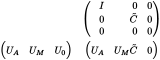

In [12]:
import itikz
from itikz import nicematrix as nM

lC = [[ "I", "0", "0"],["0", "\\tilde{C}", "0"],[ "0", "0", "0"]]
lU = [["U_A", "U_M", "U_0"]]
lUC = [["U_A", "U_M \\tilde{C}", "0"]]

layers=[ [None, lC], [lU, lUC]]
h,m = nM.ge( layers, Nrhs=[0],
             formater = lambda x:x,
             tmp_dir="tmp", keep_file="tmp/gsvd_C"
)
h

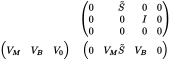

In [13]:
lS =[["0", "\\tilde{S}", "0", "0"],[ "0", "0", "I", "0"],[ "0", "0", "0", "0" ]]

lV = [["V_M", "V_B", "V_0"]]
lVS = [["0", "V_M \\tilde{S}", "V_B", "0"]]

layers=[ [None, lS], [lV, lVS]]
h,m = nM.ge( layers, Nrhs=[0],
             formater = lambda x:x,
             tmp_dir="tmp", keep_file="tmp/gsvd_S"
)
h

This notebook introduced a generalization of the **SVG** to two matrices sharing the same codomain,  
asserting the existence of **orthogonal matrices** $U$ and $V$ and an **invertible matrix** $X$,  
such that a matrix pair $(A,B)$ takes the form $(C,S)$ when expressed in their bases:  
$\qquad A = U\ C\ X^{-1}, \quad B = V\ S\ X^{-1},$

The focus was on analyzing the **structure** of these matrices.  
The next notebook [**GSVD_computations.ipynb**](GSVD_computations.ipynb) will show that such a decomposition exists.

Key observations:
- The domain is decomposed into subspaces with dimensions $ n_A $, $ n_M $, $ n_B $, and $ n_0 $,  
corresponding to directions exclusive to $A$, shared between $A$ and $B$, exclusive to $B$, and in the nullspace of both.
- The matrices $C$ and $S$ encode direction-dependent scaling. Their respective nonzero entries $c_i$ and $s_i$  
  satisfy $c_i^2 + s_i^2 = 1$, defining generalized singular values.
- The parameters $c_i = \cos(\theta_i)$, $s_i = \sin(\theta_i)$ reflect the relative contributions of $A$ and $B$  
along each mixed direction. These values capture the geometric interpretation of the GSVD.

This structural perspective clarifies how the GSVD distinguishes subspace behavior and enables geometric and numerical insight  
into the relationship between $A$ and $B$.